<a href="https://colab.research.google.com/github/leonardochd/Prevendo-valores-acoes-regressao-linear/blob/main/Prevendo_pre%C3%A7o_das_a%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pandas-datareader

!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 13.6 MB/s eta 0:00:00
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 100.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


#Criando o modelo para prever os valores das ações

####Importando as bibliotecas

In [41]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18,8)

In [42]:
stock = input("Entre a sigla do nome da ação que você quer que seja treinado (exemplo: \'mglu3.sa\' para ações da Magalu): ")


Entre a sigla do nome da ação que você quer que seja treinado (exemplo: 'mglu3.sa' para ações da Magalu): itub4.sa


####Importando o DataFrame

In [43]:
data_inicio = pd.to_datetime(['2020-01-01']).astype(int)[0]//10**9 # convertendo para unix timestamp
data_fim = pd.to_datetime(['2023-01-01']).astype(int)[0]//10**9 # convertendo para unix timestamp
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + str(stock) + '?period1=' + str(data_inicio) + '&period2=' + str(data_fim) + '&interval=1d&events=history'
df = pd.read_csv(url)

# df.head()

<ipython-input-43-10129e9025fc>:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data_inicio = pd.to_datetime(['2020-01-01']).astype(int)[0]//10**9 # convertendo para unix timestamp
<ipython-input-43-10129e9025fc>:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data_fim = pd.to_datetime(['2023-01-01']).astype(int)[0]//10**9 # convertendo para unix timestamp


In [44]:
# Criando novos campos de medias móveis com o intervalo de 7 e 21 dias de fechamento
df['mm7'] = df['Adj Close'].rolling(7).mean()
df['mm21d'] = df['Adj Close'].rolling(21).mean()

In [45]:

df['Adj Close'] = df['Adj Close'].shift(-1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,mm7,mm21d
0,2020-01-02,37.279999,38.029999,36.990002,38.029999,34.005348,20666100,NaN,NaN
1,2020-01-03,37.500000,38.240002,37.450001,37.630001,33.499294,24891400,NaN,NaN
2,2020-01-06,37.549999,37.580002,36.910000,37.070000,32.722115,22294700,NaN,NaN
3,2020-01-07,37.070000,37.240002,36.209999,36.209999,32.188965,20000900,NaN,NaN
4,2020-01-08,36.450001,36.810001,35.619999,35.619999,31.547363,25980900,NaN,NaN


Apagando os dados nulos para que o modelo não leia os dados NaN

In [46]:
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,mm7,mm21d
20,2020-01-30,32.650002,33.450001,32.580002,33.450001,29.658676,41789800,30.447453,31.501311
21,2020-01-31,32.990002,33.389999,32.540001,32.820000,29.744558,25459800,30.333849,31.277114
22,2020-02-03,33.000000,33.310001,32.790001,32.900002,29.979620,17586000,30.129236,31.074219
23,2020-02-04,33.360001,33.459999,32.900002,33.160000,30.160439,15730300,29.991769,30.906616
24,2020-02-05,33.709999,34.119999,33.360001,33.360001,30.088112,34791900,29.975664,30.784631
...,...,...,...,...,...,...,...,...,...
739,2022-12-22,24.790001,25.100000,24.469999,24.799999,25.172216,22334800,24.122957,24.753829
740,2022-12-23,25.030001,25.510000,24.870001,25.190001,24.672569,25327300,24.394194,24.696288
741,2022-12-26,24.950001,25.180000,24.549999,24.690001,24.532667,15730800,24.575494,24.659254
742,2022-12-27,24.660000,24.730000,24.270000,24.549999,25.032314,17203600,24.699692,24.637473


In [47]:
# Verificando a quantidade de linhas
qtd_linhas = len(df)

qtd_linhas_treino = round(0.5 * qtd_linhas)
qtd_linhas_teste = 300
qtd_linhas_validacao = qtd_linhas - 1

info = (
    f"linhas treino = 0:{qtd_linhas_treino} | "
    f"linhas teste = {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste - 1} | "
    f"linhas validação = {qtd_linhas_validacao}"
)

info

'linhas treino = 0:362 | linhas teste = 362:661 | linhas validação = 723'

In [48]:
df["data_pregao"] = df['Date']
df

,Date,Open,High,Low,Close,Adj Close,Volume,mm7,mm21d,data_pregao
20,2020-01-30,32.650002,33.450001,32.580002,33.450001,29.658676,41789800,30.447453,31.501311,2020-01-30
21,2020-01-31,32.990002,33.389999,32.540001,32.820000,29.744558,25459800,30.333849,31.277114,2020-01-31
22,2020-02-03,33.000000,33.310001,32.790001,32.900002,29.979620,17586000,30.129236,31.074219,2020-02-03
23,2020-02-04,33.360001,33.459999,32.900002,33.160000,30.160439,15730300,29.991769,30.906616,2020-02-04
24,2020-02-05,33.709999,34.119999,33.360001,33.360001,30.088112,34791900,29.975664,30.784631,2020-02-05
...,...,...,...,...,...,...,...,...,...,...
739,2022-12-22,24.790001,25.100000,24.469999,24.799999,25.172216,22334800,24.122957,24.753829,2022-12-22
740,2022-12-23,25.030001,25.510000,24.870001,25.190001,24.672569,25327300,24.394194,24.696288,2022-12-23
741,2022-12-26,24.950001,25.180000,24.549999,24.690001,24.532667,15730800,24.575494,24.659254,2022-12-26
742,2022-12-27,24.660000,24.730000,24.270000,24.549999,25.032314,17203600,24.699692,24.637473,2022-12-27


 Apagando a coluna 'Date' e reindexando o DataFrame

In [49]:
df = df.drop('Date', axis=1)
df = df.reset_index(drop=True)

df

,Open,High,Low,Close,Adj Close,Volume,mm7,mm21d,data_pregao
0,32.650002,33.450001,32.580002,33.450001,29.658676,41789800,30.447453,31.501311,2020-01-30
1,32.990002,33.389999,32.540001,32.820000,29.744558,25459800,30.333849,31.277114,2020-01-31
2,33.000000,33.310001,32.790001,32.900002,29.979620,17586000,30.129236,31.074219,2020-02-03
3,33.360001,33.459999,32.900002,33.160000,30.160439,15730300,29.991769,30.906616,2020-02-04
4,33.709999,34.119999,33.360001,33.360001,30.088112,34791900,29.975664,30.784631,2020-02-05
...,...,...,...,...,...,...,...,...,...
719,24.790001,25.100000,24.469999,24.799999,25.172216,22334800,24.122957,24.753829,2022-12-22
720,25.030001,25.510000,24.870001,25.190001,24.672569,25327300,24.394194,24.696288,2022-12-23
721,24.950001,25.180000,24.549999,24.690001,24.532667,15730800,24.575494,24.659254,2022-12-26
722,24.660000,24.730000,24.270000,24.549999,25.032314,17203600,24.699692,24.637473,2022-12-27


In [50]:
df_completo = df

features = df.drop(['Close', 'Adj Close', 'data_pregao'], 1)
labels = df['Adj Close']

<ipython-input-50-260aa15c80d0>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features = df.drop(['Close', 'Adj Close', 'data_pregao'], 1)


####Importando as bibliotecas

In [51]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [52]:
features_list = ('Open','High','Low','Volume','mm7','mm21d')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)


Melhores features:
{'Volume': 13.129563419590664, 'Low': 10.002029353856278, 'High': 7.82695291351254, 'mm21d': 5.617581729178372, 'mm7': 1.3436114417472464}


In [53]:
#Separa os dados de treino teste e validação
X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

362 362
299 299


In [54]:
# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

In [55]:
#treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(X_train_scale, y_train)
pred= lr.predict(X_test_scale)
cd = r2_score(y_test, pred)
MAE = mean_absolute_error(y_test, pred)


# f'Coeficiente de determinação:{cd * 100:.2f}'
print("Coeficiente de determinação: " + str(cd*100) + "%")
print("Erro médio absoluto: " + str(MAE))

Coeficiente de determinação: 89.4980396791638%
Erro médio absoluto: 0.6144443883110338


In [56]:
valor_novo = features.tail(58)
valor_novo

,Open,High,Low,Volume,mm7,mm21d
666,29.870001,30.080000,29.660000,30340200,28.006633,27.196134
667,29.900000,29.940001,29.139999,48860300,28.250925,27.314823
668,29.200001,29.320000,28.650000,56055700,28.505002,27.445158
669,29.480000,29.540001,28.790001,48372400,28.658452,27.551265
670,28.900000,29.150000,28.719999,32203000,28.765776,27.632682
671,28.500000,28.969999,28.350000,37182200,28.610588,27.719218
672,28.750000,29.170000,28.459999,40153900,28.449807,27.810877
673,28.940001,29.100000,28.700001,20382900,28.321183,27.909994
674,29.299999,29.590000,29.049999,46201600,28.367319,28.046391
675,29.559999,29.760000,29.309999,28369700,28.406466,28.136680


####Executando a previsão

In [57]:
previsao=scaler.transform(valor_novo)
pred=lr.predict(previsao)

pred

array([27.8648667 , 27.43760859, 27.38064682, 27.39387802, 27.58036681,
       27.41112745, 27.34034183, 27.21578451, 27.63875656, 27.66565046,
       28.28075436, 28.84420714, 27.60204081, 27.94540677, 27.66567304,
       27.86466544, 27.9061458 , 28.66079119, 28.16591069, 27.95998523,
       28.46597929, 27.98541045, 27.91748405, 27.44306267, 26.73245595,
       25.80021548, 25.52286167, 24.91977053, 25.18494222, 25.17673245,
       24.75198988, 24.60270993, 24.57376845, 25.06781202, 24.28899899,
       24.14426091, 24.11318342, 24.27652262, 24.586681  , 24.54331153,
       23.93025748, 24.5271725 , 24.42994206, 23.76540022, 23.30806266,
       23.21551799, 22.28528558, 22.54130246, 22.5990361 , 22.66719824,
       22.93696686, 23.37581393, 23.31413313, 23.2350393 , 23.76351894,
       23.38186842, 23.2016458 , 23.66390848])

In [58]:
data_pregao_full=df_completo['data_pregao']
data_pregao=data_pregao_full.tail(58)

res_full=df_completo['Adj Close']
res=res_full.tail(58)

df=pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao':pred})


df.set_index('data_pregao', inplace=True)

df.head()

,real,previsao
data_pregao,,
2022-10-05,28.635754,27.864867
2022-10-06,28.694475,27.437609
2022-10-07,28.391088,27.380647
2022-10-10,28.195353,27.393878
2022-10-11,28.028982,27.580367


####Plotando o gráfico

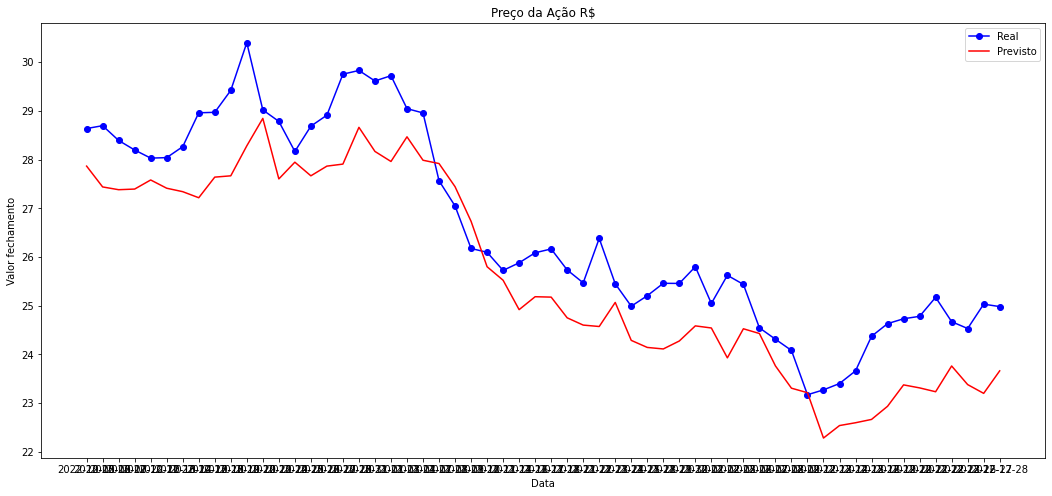

In [59]:
plt.title("Preço da Ação R$")
plt.plot(df["real"],label = "Real", color = "blue", marker = 'o')
plt.plot(df["previsao"],label = "Previsto", color = "red")
plt.xlabel("Data")
# plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45)
plt.ylabel("Valor fechamento")
plt.legend()

In [60]:
for index, row in df.iterrows():
    df.loc[index,'diferenca'] = (df.loc[index,'real'] - df.loc[index,'previsao']);


df.head()

,real,previsao,diferenca
data_pregao,,,
2022-10-05,28.635754,27.864867,0.770887
2022-10-06,28.694475,27.437609,1.256866
2022-10-07,28.391088,27.380647,1.010441
2022-10-10,28.195353,27.393878,0.801475
2022-10-11,28.028982,27.580367,0.448615
